# PIC16B HW4: Image Classification

Instructions from <https://pic16b.quarto.pub/pic-16b-w23/posts/hw4/>

*Reference: <https://www.tensorflow.org/tutorials/images/transfer_learning>*

## 0. Load Packages and Obtain Data

Start by making a code block in which you’ll hold your import statements. You can update this block as you go. For now, include

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import utils 

Now, let’s access the data. We’ll use a sample data set provided by the TensorFlow team that contains labeled images of cats and dogs.

Paste and run the following code block.

In [2]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


By running this code, we have created TensorFlow Datasets for training, validation, and testing. You can think of a Dataset as a pipeline that feeds data to a machine learning model. We use data sets in cases in which it’s not necessarily practical to load all the data into memory.

In our case, we’ve used a special-purpose `keras` utility called `image_dataset_from_directory` to construct a `Dataset`. 

- The most important argument is the first one, which says *where* the images are located. 
- The `shuffle` argument says that, when retrieving data from this directory, the order should be randomized. 
- The `batch_size` determines how many data points are gathered from the directory at once. Here, for example, each time we request some data we will get 32 images from each of the data sets. 
- Finally, the `image_size` specifies the size of the input images, just like you’d expect.

Paste the following code into the next block. This is technical code related to rapidly reading data. If you’re interested in learning more about this kind of thing, you can take a look at https://www.tensorflow.org/guide/data_performance.

In [3]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Working with Datasets

You can get a piece of a data set using the take method, e.g. `train_dataset.take(1)` will retrieve one batch (32 images with labels) from the training data.

Let’s briefly explore our data set. **Write a function to create a two-row visualization**. In the first row, show three random pictures of cats. In the second row, show three random pictures of dogs. You can see some related code in the linked tutorial above, although you’ll need to make some modifications in order to separate cats and dogs by rows. A docstring is not required.

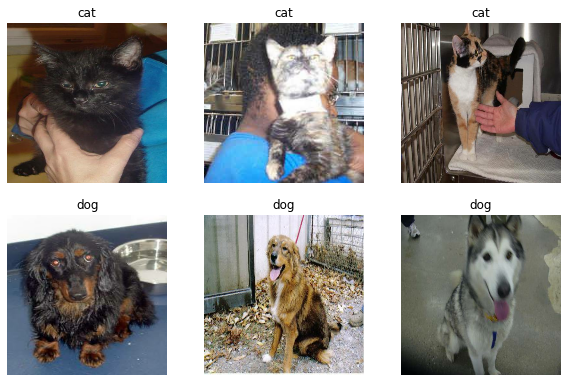

In [4]:
import matplotlib.pyplot as plt

def plot_dataset(train_dataset):
  plt.figure(figsize=(10,10))

  for images, labels in train_dataset.take(1):
    for i in range(6):
      #subplot needs 3 arguments
      ax = plt.subplot(3,3,i+1)
      
      #original code in linked tutorial above:
      #plt.imshow(images[i].numpy().astype("uint8"))
      
      #for the first row, print random cat images and label `cat`
      #by using the mask `labels==0` on `images`
      if i in range(3):
        cat_images=images[labels==0]
        plt.imshow(cat_images[i].numpy().astype("uint8"))
        plt.title("cat")
      
      #for the second row, print random dog images and label `dog`
      #by using the mask `labels==1` on `images`
      else:
        dog_images=images[labels==1]
        plt.imshow(dog_images[i].numpy().astype("uint8"))
        plt.title("dog")
      
      plt.axis("off")

plot_dataset(train_dataset)

## Check Label Frequencies

The following line of code will create an iterator called `labels`.

In [5]:
labels_iterator = train_dataset.unbatch().map(lambda image, label: label).as_numpy_iterator()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Compute the number of images in the training data with label `0` (corresponding to `"cat"`) and label `1` (corresponding to `"dog"`).

In [6]:
#initiate counts
label_0=0
label_1=0

for label in labels_iterator:
  
  #for cat
  if label==0:
    label_0+=1
  
  #for dog
  else:
    label_1+=1
  
print(label_0,label_1)

1000 1000



The *baseline* machine learning model is the model that always guesses the most frequent label. Briefly discuss how accurate the baseline model would be in our case.

We’ll treat this as the benchmark for improvement. Our models should do much better than baseline in order to be considered good data science achievements!

> The baseline machine learning model has an accuracy of 50%, since we have 1,000 cat images and 1,000 dog images, as discussed above. 

## 1. First Model

Create a `tf.keras.Sequential` model using some of the layers we’ve discussed in class. In each model, include at least two `Conv2D` layers, at least two `MaxPooling2D` layers, at least one `Flatten` layer, at least one `Dense` layer, and at least one `Dropout` layer. Train your model and plot the history of the accuracy on both the training and validation sets. Give your model the name `model1`.

To train a model on a `Dataset`, use syntax like this:



```
history = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation)
```



Here and in later parts of this assignment, training for 20 epochs with the `Dataset` settings described above should be sufficient.

You don’t have to show multiple models, but please do a few experiments to try to get the best validation accuracy you can. Briefly describe a few of the things you tried. Please make sure that you are able to consistently achieve **at least** 52% validation accuracy in this part (i.e. just a bit better than baseline).

> #### Experiment Attempts
I tried adding more `Conv2D` and `MaxPooling2D` layers, using different numbers of filters on `Conv2D` layers, or putting the `Dropout` layers in different places. I also tried using a different dimension of kernel such as `(2,2)`, which had a lower validation accuracy than my `(3,3)` kernel. Otherwise, the above combinations didn't yield significantly better results, so I stick to the current layers. 

### `Model1` Configuration

In [36]:
#configure layers for model1

import tensorflow as tf
from tensorflow.keras import layers, models

model1 = models.Sequential([
      #the first conv2d layer needs input_shape input
      layers.Conv2D(32,(3,3), activation='relu', input_shape=(160,160,3)),
      layers.MaxPooling2D((3,3)),
      #layers.Dropout(0.2), #dropout layer to randomly delete % sample data, typically after conv2d and maxpooling2d

      layers.Conv2D(32,(3,3), activation='relu'),
      layers.MaxPooling2D((3,3)),
      #layers.Dropout(0.2),
      
      layers.Flatten(), #into a long single vector
      
      layers.Dropout(0.2),
      layers.Dense(64, activation='relu'),
      layers.Dense(2), #for binary classification of dog vs cat
])

In [37]:
#compile model
model1.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

#fit model on training dataset and validate on validating dataset
history1 = model1.fit(train_dataset,
                      epochs=20, 
                      validation_data=validation_dataset)

Epoch 1/20
63/63 [==============================] - 5s 50ms/step - loss: 18.1178 - accuracy: 0.5200 - val_loss: 0.6987 - val_accuracy: 0.5582
Epoch 2/20
63/63 [==============================] - 4s 65ms/step - loss: 0.6362 - accuracy: 0.6295 - val_loss: 0.7010 - val_accuracy: 0.5693
Epoch 3/20
63/63 [==============================] - 3s 48ms/step - loss: 0.5312 - accuracy: 0.7305 - val_loss: 0.7184 - val_accuracy: 0.5854
Epoch 4/20
63/63 [==============================] - 3s 48ms/step - loss: 0.4405 - accuracy: 0.7835 - val_loss: 0.7696 - val_accuracy: 0.5916
Epoch 5/20
63/63 [==============================] - 4s 63ms/step - loss: 0.3412 - accuracy: 0.8510 - val_loss: 0.8552 - val_accuracy: 0.5631
Epoch 6/20
63/63 [==============================] - 3s 48ms/step - loss: 0.2810 - accuracy: 0.8855 - val_loss: 1.0619 - val_accuracy: 0.5792
Epoch 7/20
63/63 [==============================] - 3s 48ms/step - loss: 0.2311 - accuracy: 0.9035 - val_loss: 1.0666 - val_accuracy: 0.5681
Epoch 8/20
6

### `Model1` Summary

1. In **bold** font, describe the validation accuracy of your model during training. You don’t have to be precise. For example, *“the accuracy of my model stabilized between 65% and 70% during training.”*

- **The validation accuracy of `model1` stabilized between 55% and 59% during training.**



---


2. Then, compare that to the baseline. How much better did you do?

- The baseline accuracy is 50%, so my `model1` has a higher accuracy, but only better for within 10%. 


---



3. *Overfitting* can be observed when the training accuracy is much higher than the validation accuracy. Do you observe overfitting in `model1`?

- Yes, I do observe an overfitting pattern in `model1`, especially in later epoches where the gap even widens (see graph below). 

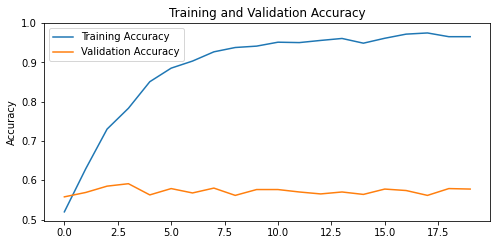

In [38]:
#plot learning curves of training accuracy and validation accuracy
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']

loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc1, label='Training Accuracy')
plt.plot(val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.legend()

## 2. Model with Data Augmentation

Now we’re going to add some *data augmentation* layers to your model. Data augmentation refers to the practice of including modified copies of the same image in the training set. For example, a picture of a cat is still a picture of a cat even if we flip it upside down or rotate it 90 degrees. We can include such transformed versions of the image in our training process in order to help our model learn so-called invariant features of our input images.

1. First, create a `tf.keras.layers.RandomFlip()` layer. Make a plot of the original image and a few copies to which `RandomFlip()` has been applied. Make sure to check the documentation for this function!

> See *Data augmentation* section at <https://www.tensorflow.org/tutorials/images/data_augmentation>

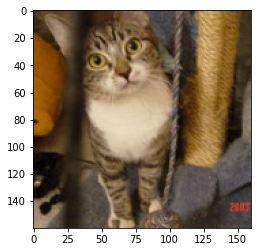

In [30]:
#add the flip layer
flip = models.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
])

#apply the flip layer on an image
for images, labels in train_dataset.take(1):
  flipped_images = flip(images)

#original image
plt.imshow(images[0].numpy().astype("uint8"))

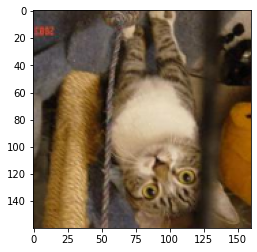

In [31]:
#flipped image
plt.imshow(flipped_images[0].numpy().astype("uint8"))

2. Next, create a `tf.keras.layers.RandomRotation()` layer. Check the docs to learn more about the arguments accepted by this layer. Then, make a plot of both the original image and a few copies to which `RandomRotation()` has been applied.


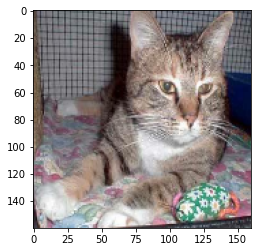

In [50]:
#add a rotate layer
rotate = models.Sequential([
  tf.keras.layers.RandomRotation(0.2),
])

#apply the rotate layer on an image
for images, labels in train_dataset.take(1):
  rotated_images = rotate(images)

#original image
plt.imshow(images[0].numpy().astype("uint8"))

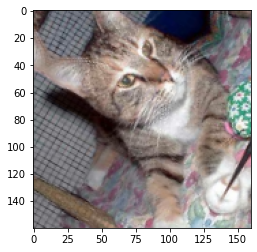

In [51]:
#rotated image
plt.imshow(rotated_images[0].numpy().astype("uint8"))

### `Model2` Configuration

Now, create a new `tf.keras.models.Sequential` model called `model2` in which the first two layers are augmentation layers. Use a `RandomFlip() layer` and a `RandomRotation()` layer. Train your model, and visualize the training history.

Please make sure that you are able to consistently achieve **at least** 55% validation accuracy in this part. Scores of near 60% are possible.

**Note**: You might find that your model in this section performs a bit worse than the one before, even on the validation set. If so, just comment on it! That doesn’t mean there’s anything wrong with your approach. We’ll see improvements soon.

In [52]:
#configure the data augmentation layer: flip + rotate
data_augmentation = models.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [53]:
#configure layers for model2
model2 = models.Sequential([
      data_augmentation, #add data augmentation layer to model1

      #the first conv2d layer needs input_shape input
      layers.Conv2D(32,(3,3), activation='relu', input_shape=(160,160,3)),
      layers.MaxPooling2D((3,3)),
      #layers.Dropout(0.2), #dropout layer to randomly delete % sample data, typically after conv2d and maxpooling2d

      layers.Conv2D(32,(3,3), activation='relu'),
      layers.MaxPooling2D((3,3)),
      #layers.Dropout(0.2),
      
      layers.Flatten(), #into a long single vector
      
      layers.Dropout(0.2),
      layers.Dense(64, activation='relu'),
      layers.Dense(2), #for binary classification of dog vs cat
])

In [59]:
#compile model2
model2.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

#fit model2 on training dataset and validate on validation dataset
history2 = model2.fit(train_dataset,
                      epochs=20, 
                      validation_data=validation_dataset)

Epoch 1/20


63/63 [==============================] - 11s 126ms/step - loss: 0.6019 - accuracy: 0.6900 - val_loss: 0.6306 - val_accuracy: 0.6448
Epoch 2/20
63/63 [==============================] - 8s 124ms/step - loss: 0.6134 - accuracy: 0.6645 - val_loss: 0.6636 - val_accuracy: 0.6745
Epoch 3/20
63/63 [==============================] - 8s 116ms/step - loss: 0.5962 - accuracy: 0.6825 - val_loss: 0.6625 - val_accuracy: 0.6634
Epoch 4/20
63/63 [==============================] - 8s 117ms/step - loss: 0.5884 - accuracy: 0.6920 - val_loss: 0.6709 - val_accuracy: 0.6535
Epoch 5/20
63/63 [==============================] - 8s 125ms/step - loss: 0.5947 - accuracy: 0.6785 - val_loss: 0.6397 - val_accuracy: 0.6151
Epoch 6/20
63/63 [==============================] - 7s 109ms/step - loss: 0.5823 - accuracy: 0.6960 - val_loss: 0.6549 - val_accuracy: 0.6386
Epoch 7/20
63/63 [==============================] - 8s 125ms/step - loss: 0.6165 - accuracy: 0.6750 - val_loss: 0.6582 - val_accuracy: 0.6621
Epoch 8/20
63/63

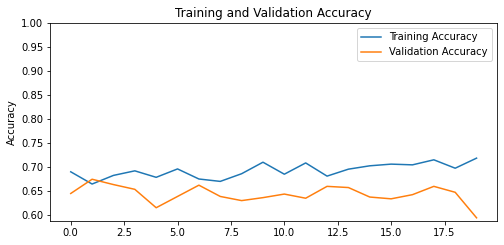

In [60]:
#plot learning curves of training accuracy and validation accuracy
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']

loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc2, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.legend()

### `Model2` Summary

1. In **bold** font, describe the validation accuracy of your model during training.

- **The validation accuracy of my `model2` settled between 59% and 68% during training.**

---


2. Comment on this validation accuracy in comparison to the accuracy you were able to obtain with `model1`.

- This validation accuracy is higher than that of `model1`, because we were able to add the data augmentation layer to adjust for minor image rotation and flipping situations.  

---


3. Comment again on overfitting. Do you observe overfitting in `model2`?

- I observe some intermittent patterns of overfitting *and* underfitting in `model2`, because the validation accuracy and training accuracy fluctuate above and below while staying close to each other, which is different from `model1`. 

## 3. Data Preprocessing

Sometimes, it can be helpful to make simple transformations to the input data. For example, in this case, the original data has pixels with RGB values between 0 and 255, but many models will train faster with RGB values normalized between 0 and 1, or possibly between -1 and 1. These are mathematically identical situations, since we can always just scale the weights. But if we handle the scaling prior to the training process, we can spend more of our training energy handling actual signal in the data and less energy having the weights adjust to the data scale.

The following code will create a preprocessing layer called `preprocessor` which you can slot into your model pipeline.

In [62]:
#configure preprocessing layer: normalization
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

### `Model3` Configuration

I suggest incorporating the `preprocessor` layer as the very first layer, before the data augmentation layers. Call the resulting model `model3`.

Now, train this model and visualize the training history. This time, please make sure that you are able to achieve **at least** 70% validation accuracy.

In [63]:
#configure layers for model3
model3 = models.Sequential([
      preprocessor, #add preprocessing layer on model2

      data_augmentation,

      #the first conv2d layer needs input_shape input
      layers.Conv2D(32,(3,3), activation='relu', input_shape=(160,160,3)),
      layers.MaxPooling2D((3,3)),
      #layers.Dropout(0.2), #dropout layer to randomly delete % sample data, typically after conv2d and maxpooling2d

      layers.Conv2D(32,(3,3), activation='relu'),
      layers.MaxPooling2D((3,3)),
      #layers.Dropout(0.2),
      
      layers.Flatten(), #into a long single vector
      
      layers.Dropout(0.2),
      layers.Dense(64, activation='relu'),
      layers.Dense(2), #for binary classification of dog vs cat
])

In [65]:
#compile model3
model3.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

#fit model3 onn training dataset and validate on validation dataset
history3 = model3.fit(train_dataset,
                      epochs=20, 
                      validation_data=validation_dataset)

Epoch 1/20


63/63 [==============================] - 11s 122ms/step - loss: 0.4820 - accuracy: 0.7770 - val_loss: 0.5205 - val_accuracy: 0.7463
Epoch 2/20
63/63 [==============================] - 7s 114ms/step - loss: 0.4745 - accuracy: 0.7815 - val_loss: 0.4787 - val_accuracy: 0.7785
Epoch 3/20
63/63 [==============================] - 8s 124ms/step - loss: 0.4559 - accuracy: 0.7865 - val_loss: 0.4767 - val_accuracy: 0.7797
Epoch 4/20
63/63 [==============================] - 8s 125ms/step - loss: 0.4454 - accuracy: 0.7835 - val_loss: 0.4747 - val_accuracy: 0.7735
Epoch 5/20
63/63 [==============================] - 8s 121ms/step - loss: 0.4386 - accuracy: 0.7945 - val_loss: 0.4956 - val_accuracy: 0.7698
Epoch 6/20
63/63 [==============================] - 8s 121ms/step - loss: 0.4417 - accuracy: 0.8015 - val_loss: 0.4637 - val_accuracy: 0.7797
Epoch 7/20
63/63 [==============================] - 8s 125ms/step - loss: 0.4432 - accuracy: 0.7940 - val_loss: 0.4815 - val_accuracy: 0.7698
Epoch 8/20
63/63

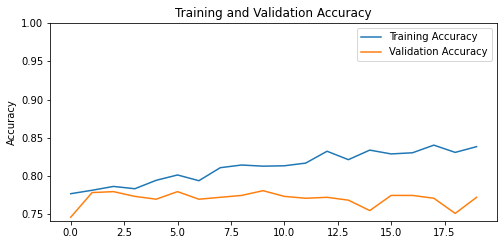

In [66]:
#plot learning curves of training accuracy and validation accuracy
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc3, label='Training Accuracy')
plt.plot(val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.legend()

### `Model3` Summary

1. In **bold** font, describe the validation accuracy of your model during training.

- **The validation accuracy of `model3` was between 74% and 79%.**

---

2. Comment on this validation accuracy in comparison to the accuracy you were able to obtain with `model1`.

- This validation accuracy is higher than that of `model1`, about 20% higher.

---


3. Comment again on overfitting. Do you observe overfitting in `model3`?

- I observe a pattern of overfitting in `model3`, because the validation accuracy is consistently lower than training accuracy, similar to `model1` but the range of difference is smaller than that of `model1`.

## 4. Transfer Learning

So far, we’ve been training models for distinguishing between cats and dogs from scratch. In some cases, however, someone might already have trained a model that does a related task, and might have learned some relevant patterns. For example, folks train machine learning models for a variety of image recognition tasks. Maybe we could use a pre-existing model for our task?

To do this, we need to first access a pre-existing “base model”, incorporate it into a full model for our current task, and then train that model.

Paste the following code in order to download `MobileNetV2` and configure it as a layer that can be included in your model.

In [67]:
#configure transfer learning layer
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

9406464/9406464 [==============================] - 0s 0us/step


### `Model4` Configuration

Now, create a model called `model4` that uses `MobileNetV2`. For this, you should definitely use the following layers:

1. The `preprocessor` layer from Part §4.
2. The data augmentation layers from Part §3.
3. The `base_model_layer` constructed above.
4. A `Dense(2)` layer at the very end to actually perform the classification.

Between 3. and 4., you might want to place a small number of additional layers, like `GlobalMaxPooling2D` or possibly `Dropout`. You don’t need a lot though! 

In [69]:
model4 = models.Sequential([
      preprocessor,
      data_augmentation,
      base_model_layer, #add transfer learning layer on model3

      #delete a few layers from model3 so that the model can allow parameters to train normally
      
      layers.Conv2D(32,(3,3), activation='relu', input_shape=(160,160,3)),
      #layers.MaxPooling2D((3,3)),
      #layers.Dropout(0.2),
      
      #layers.Conv2D(32,(3,3), activation='relu'),
      #layers.MaxPooling2D((3,3)),
      #layers.Dropout(0.2),
      
      layers.Flatten(), #into a long single vector
      #layers.Dropout(0.2),
      #layers.Dense(64, activation='relu'),
      layers.Dense(2), #for binary classification of dog vs cat
])

Finally, train your model for 20 epochs, and visualize the training history.

This time, please make sure that you are able to achieve **at least 95% validation accuracy**. That’s not a typo!

In [71]:
#compile model4
model4.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

#fit model4 on training dataset and validate on validation dataset
history4 = model4.fit(train_dataset,
                      epochs=20, 
                      validation_data=validation_dataset)

Epoch 1/20


63/63 [==============================] - 16s 158ms/step - loss: 0.0501 - accuracy: 0.9825 - val_loss: 0.0667 - val_accuracy: 0.9740
Epoch 2/20
63/63 [==============================] - 10s 148ms/step - loss: 0.0318 - accuracy: 0.9885 - val_loss: 0.1453 - val_accuracy: 0.9703
Epoch 3/20
63/63 [==============================] - 8s 131ms/step - loss: 0.0553 - accuracy: 0.9850 - val_loss: 0.0991 - val_accuracy: 0.9777
Epoch 4/20
63/63 [==============================] - 11s 165ms/step - loss: 0.0383 - accuracy: 0.9860 - val_loss: 0.0821 - val_accuracy: 0.9839
Epoch 5/20
63/63 [==============================] - 9s 143ms/step - loss: 0.0384 - accuracy: 0.9880 - val_loss: 0.1433 - val_accuracy: 0.9740
Epoch 6/20
63/63 [==============================] - 9s 140ms/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 0.0746 - val_accuracy: 0.9777
Epoch 7/20
63/63 [==============================] - 8s 128ms/step - loss: 0.0467 - accuracy: 0.9875 - val_loss: 0.0982 - val_accuracy: 0.9777
Epoch 8/20
63/

Once you’ve constructed the model, check the `model.summary()` to see why – there is a LOT of complexity hidden in the `base_model_layer`. Show the summary and comment. How many parameters do we have to train in the model?

In [72]:
model4.summary() #overview: train on 2,257,984 parameters

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 160, 160, 3)       0         
                                                                 
 sequential_21 (Sequential)  (None, 160, 160, 3)       0         
                                                                 
 model_1 (Functional)        (None, 5, 5, 1280)        2257984   
                                                                 
 conv2d_35 (Conv2D)          (None, 3, 3, 32)          368672    
                                                                 
 flatten_17 (Flatten)        (None, 288)               0         
                                                                 
 dense_30 (Dense)            (None, 2)                 578       
                                                                 
Total params: 2,627,234
Trainable params: 369,250
Non

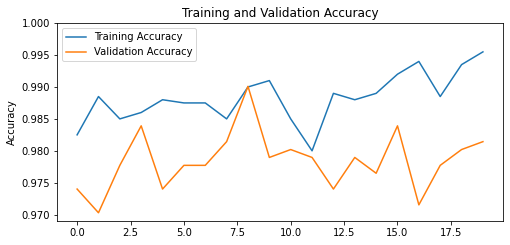

In [73]:
#plot learning curves of training accuracy and validation accuracy
acc4 = history4.history['accuracy']
val_acc4 = history4.history['val_accuracy']

loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc4, label='Training Accuracy')
plt.plot(val_acc4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.legend()

### `Model4` Summary

1. In **bold** font, describe the validation accuracy of your model during training.

- **The validation accuracy for my `model4` settled between 97% and 99%.**

---

2. Comment on this validation accuracy in comparison to the accuracy you were able to obtain with `model4`.

- This validation accuracy was about much higher than that of my `model1`, about 40% better. 

---

3. Comment again on overfitting. Do you observe overfitting in `model4`?

I observe an overall overfitting patterns of overfitting in `model4`, because the validation accuracy is lower than the training accuracy, similar to `model1` but the range of difference is much smaller than that of `model1`. 

## 5. Score on Test Data

Feel free to mess around with various model structures and settings in order to get the best validation accuracy you can. Finally, evaluate the accuracy of your most performant model on the unseen `test_dataset`. How’d you do?

In [74]:
#observe the most performant score on testing dataset from model4
loss, accuracy = model4.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 41ms/step - loss: 0.0573 - accuracy: 0.9896
Test accuracy : 0.9895833134651184


Since `model4` has the highest validation accuracy, I evaluated the test accuracy using my `model4`, which produced a 98.96% accuracy.